In [1]:
import numpy as np
import pandas as pd
import time
import pickle
import warnings
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="muted")

import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.nn import functional as F

from structure.data import HMM_Data
from structure.model import ConvNet
from structure.pattern import PatternMatching
from structure.graphics import visualize_secondary_structure
from structure.utils import *
from structure.data_extraction import from_fasta_to_df, from_df_to_fasta

from config import DATA
from pgm.data import SequenceStructureData
from pgm.layers import GaussianLayer, OneHotLayer, DReLULayer
from pgm.edge import Edge
from pgm.model import MRF
from pgm.metrics import aa_acc, l1b_reg, msa_mean, ZeroSumGauge
from pgm.train import train, val, LAYERS_NAME

import sys

torch.cuda.is_available()
device = torch.device('cpu')
warnings.filterwarnings("ignore")

In [2]:
DATASET = "PF07736"

batch_size = 300
q = 21
N = 31
k = 10
lamb_l1b = 0.025
gamma = lamb_l1b/(2*q*N)

## SS3 prediction

In [9]:
class HMM_Data(object):
    def __init__(self, file):
        self.primary, self.ss3 = [], []
        data = pickle.load(open(file, 'rb'))
        self.primary = [p[:,:50] for p in data.values()]

    def __len__(self):
        return len(self.primary)
    
    def __getitem__(self, i):
        return self.primary[i]
    
def predict():
    mean_ss3_acc, mean_ss8_acc, n_res = 0,0,0
    model_ss3.eval()
#     denoiser.eval()
    predictions = []
    for batch_idx, data in enumerate(loader):
#         if batch_idx == 300:
#             break
        x = data.float().permute(0, 2, 1).to(device)[:,:40]
        B,_,N = x.size()

        optimizer.zero_grad()
        p_other, p_ss8, p_ss3 = model_ss3(x)
        p_other, p_ss8, p_ss3 = p_other.cpu(), p_ss8.cpu(), p_ss3.cpu()
        x = x.cpu()
        
        p_ss3 = F.softmax(p_ss3,1)
        p_ss8 = F.softmax(p_ss8,1)
        predictions.append(p_ss3[0].permute(1,0).detach().numpy())

    return predictions

In [16]:
dataset = HMM_Data(f"{DATA}/{DATASET}/dca/hmm.pkl")
loader = DataLoader(dataset, batch_size = 1,
                        shuffle=False, drop_last=False)

In [17]:
N, qx, qs, h = 128, 40, 3, 8
# del model
device = torch.device('cpu')

# del model
model_ss3 = ConvNet(qx, qs)
model_ss3 = model_ss3.to(device)
optimizer = optim.Adam(model_ss3.parameters(), lr=0.001)
model_ss3.load_state_dict(torch.load(f"{DATA}/secondary_structure/model_40feats.h5"))
start = time.time()

model_ss3

ConvNet(
  (conv1): ResBlock(
    (conv_1): ConvBlock(
      (conv): Conv1d(40, 100, kernel_size=(11,), stride=(1,), padding=(5,))
      (activation): LeakyReLU(negative_slope=0.2)
      (normalization): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2): ConvBlock(
      (conv): Conv1d(40, 100, kernel_size=(1,), stride=(1,))
      (normalization): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (conv2): ResBlock(
    (conv_1): ConvBlock(
      (conv): Conv1d(100, 200, kernel_size=(11,), stride=(1,), padding=(5,))
      (activation): LeakyReLU(negative_slope=0.2)
      (normalization): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2): ConvBlock(
      (conv): Conv1d(100, 200, kernel_size=(1,), stride=(1,))
      (normalization): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (conv3): ResBlock(
    (c

In [18]:
ss_prediction = predict()
pickle.dump(ss_prediction, open(f"{DATA}/{DATASET}/dca/ss3.pkl", "wb"))
del ss_prediction

## Pattern Matching

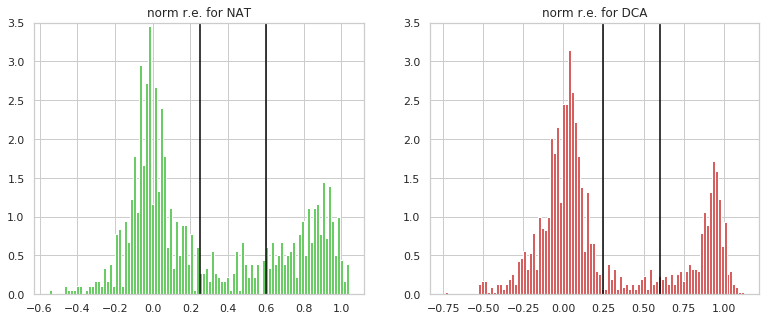

In [3]:
df = pd.read_csv(f"{DATA}/{DATASET}/table_seq.csv")
df["T"] = df["T"].fillna(0)
df["is_active"] = df["norm r.e."].apply(lambda x : int(x >= 0.6))
df["is_inactive"] = df["norm r.e."].apply(lambda x : int(x < 0.25))
df["edca_below_50"] = df["EDCA (rel. to EcCM)"].apply(lambda e : int(e < 50))
df["edca_below_25"] = df["EDCA (rel. to EcCM)"].apply(lambda e : int(e < 25))
excluded_idx = df[df.origin == "PROF"].index.values
df = df[df.origin != "PROF"]

plt.figure(figsize = (13,5))
for i, (name, col) in enumerate(zip(['NAT', 'DCA'], ["g","r"])):
    plt.subplot(1, 2, i+1)
    plt.ylim(0,3.5)
    plt.plot([0.25,0.25],[-0.5, 4],c="black")
    plt.plot([0.6,0.6],[-0.5, 4], c="black")
    plt.hist(df[df.origin == name]["norm r.e."], bins = 100, normed = True, color =col)
    plt.title(f"norm r.e. for {name}")
plt.show()

In [4]:
n_patterns, c_patterns, _ =  pickle.load(open(f"{DATA}/{DATASET}/dca/patterns.pkl","rb"))
regexes = []
for x in n_patterns:
    if len(x):
        regexes.append([(i,None,None) if i <= 2 else (i,3,None) for i in x])
Q,T,pi = pickle.load(open(f"{DATA}/secondary_structure/statistics.pkl", "rb"))
inf = float("Inf")
x, y, z, t = np.where(Q > -inf)
Q[x,y,z,t] = 0
T = torch.zeros(*T.shape)
matchers = [PatternMatching(pattern = regex, 
                            Q = Q, T = T, pi = pi,
                            name = name) for regex, name in zip(regexes, c_patterns)]
data = pickle.load(open(f"{DATA}/{DATASET}/dca/ss3.pkl","rb"))

3074it [00:53, 57.22it/s]
3074it [01:02, 48.82it/s]


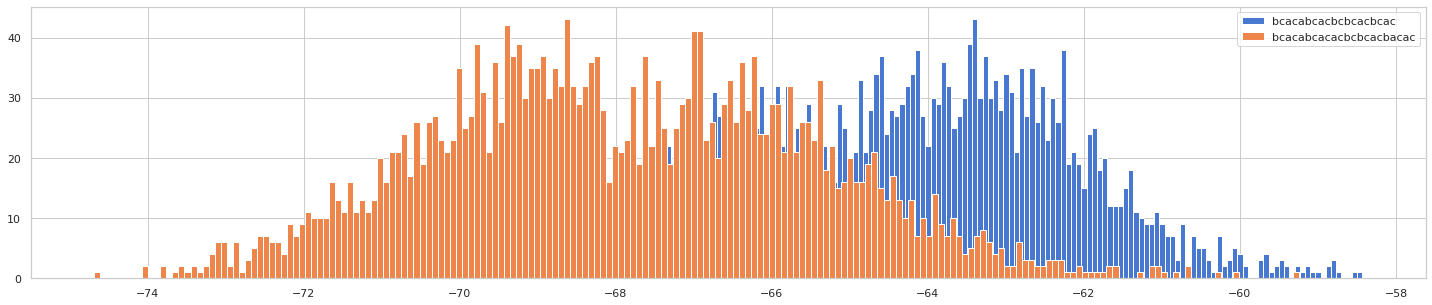

In [5]:
costs, ss, lss = [], [], []
for matcher in matchers:
    costs_, ss_, lss_ = [], [], []
    len_pat = len(matcher.pattern)
    for i, sample in tqdm(enumerate(data)):
        if i in excluded_idx:
            continue
        sample = torch.tensor(sample)
        N = sample.size(0)
        p, ll, a, b, P ,Q = matcher.match(sample)
        t = a[:-1].view(len_pat,-1,1)+b[1:].view(len_pat,1,-1)+P[0, matcher.pattern]+Q[0, matcher.pattern]-a[-1,-1]
        lss_.append(t); ss_.append(p); costs_.append((ll,a[-1,-1]))
    lss.append(lss_); ss.append(ss_); costs.append(costs_)
    
plt.figure(figsize=(25,5))
excluded_pattern = ["cbc", "acaca"]
costs2 = torch.tensor([[c[1].item() for c in cs] for cs in costs]).t()
df["P_R"] = costs2[:,1]
for cs, m in zip(costs2.t(), c_patterns):
    if m in excluded_pattern:
        continue
    plt.hist(cs, bins = 200)
plt.legend([c for c in c_patterns if c not in excluded_pattern])
plt.show()

## Computation of the SSQA

In [6]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_fscore_support
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.manifold import SpectralEmbedding
from sklearn.preprocessing import PolynomialFeatures

def where(a, conditioning):
    return a[df[conditioning].index.values]

In [7]:
cs, ts = costs[1], lss[1]
a = np.zeros((len(ts), len(ts[0]), 30))
for i, t in enumerate(ts):
    for j in range(30):
        a[i, :, j] = np.trace(torch.exp(t).numpy(), offset = j, axis1 = 1, axis2 = 2)

In [9]:
active_nat = where(a, (df.edca_below_50 == 1) & (df.origin == "NAT") & (df.is_active)).mean()
# active_nat = a[0]

X = np.array([(active_nat * (np.log(active_nat+1e-8) - np.log(x+1e-8))).sum(-1) for x in a])
X = np.array([(active_nat * (np.log(active_nat+1e-8) - np.log(x+1e-8))).sum(-1) for x in a])
X = np.append(X,df["EDCA (rel. to EcCM)"].values.reshape(len(df),1),axis = 1)

scaler = StandardScaler()

X_train = where(X, (df.edca_below_50 == 1) & (df.origin == "NAT") & ((df.is_active + df.is_inactive) > 0))
X_train = scaler.fit_transform(X_train)
# y_train = df[df.origin == "NAT"]["norm r.e."]
y_train = df[(df.edca_below_50 == 1) & (df.origin == "NAT") & ((df.is_active + df.is_inactive) > 0)]["is_active"].values

X_test = where(X, (df.edca_below_50 == 1) & (df.origin == "DCA")  & ((df.is_active + df.is_inactive) > 0))
X_test = scaler.transform(X_test)
# y_test = df[df.origin == "DCA"]["norm r.e."]
y_test = df[(df.edca_below_50 == 1) & (df.origin == "DCA")  & ((df.is_active + df.is_inactive) > 0)]["is_active"].values

clf = LogisticRegression(class_weight = "balanced").fit(X_train, y_train)
pred = clf.predict_proba(X_test)[:,1]
df["struct QA"] = clf.predict_proba(scaler.transform(X))[:,1]

In [10]:
edca = df[(df.edca_below_50 == 1) &(df.origin == "DCA")  & ((df.is_active + df.is_inactive) > 0)]["EDCA (rel. to EcCM)"].values

## Analysis

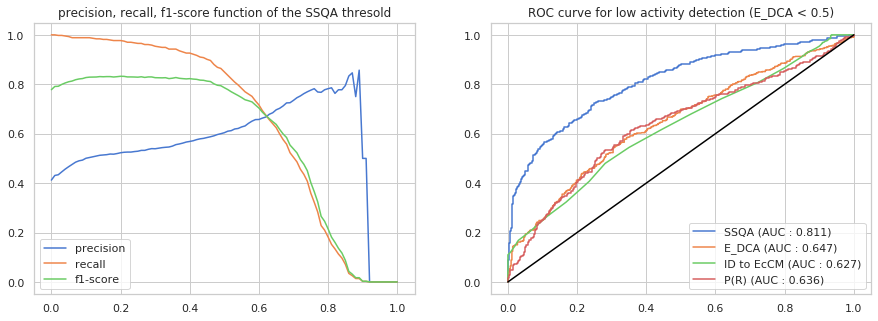

In [11]:
ps, rs, f1s = [],[],[]
for t in np.arange(0.,1.01,0.01):
    p, r, f1, _ = precision_recall_fscore_support(1-y_test, np.array(clf.predict_proba(X_test)[:,1] < t, dtype = int), beta = 2)
    ps.append(p[0]), rs.append(r[0]), f1s.append(f1[0])

plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(np.arange(0.,1.01,0.01), ps)
plt.plot(np.arange(0.,1.01,0.01), rs)
plt.plot(np.arange(0.,1.01,0.01), f1s)
plt.legend(["precision", "recall", "f1-score"])
plt.title("precision, recall, f1-score function of the SSQA thresold")

plt.subplot(122)
legs = []
fpr, tpr, _ = roc_curve(1-y_test, 1-pred)
plt.plot(fpr, tpr)
legs.append(f"SSQA (AUC : {auc(fpr, tpr):.3f})")

fpr, tpr, _ = roc_curve(1-y_test, df[(df.edca_below_50 == 1) &(df.origin == "DCA")  & ((df.is_active + df.is_inactive) > 0)]["EDCA (rel. to EcCM)"])
plt.plot(fpr, tpr)
legs.append(f"E_DCA (AUC : {auc(fpr, tpr):.3f})")

fpr, tpr, _ = roc_curve(1-y_test, -df[(df.edca_below_50 == 1) &(df.origin == "DCA")  & ((df.is_active + df.is_inactive) > 0)]["ID to EcCM"])
plt.plot(fpr, tpr)
legs.append(f"ID to EcCM (AUC : {auc(fpr, tpr):.3f})")

fpr, tpr, _ = roc_curve(1-y_test, df[(df.edca_below_50 == 1) &(df.origin == "DCA")  & ((df.is_active + df.is_inactive) > 0)]["P_R"])
plt.plot(fpr, tpr)
legs.append(f"P(R) (AUC : {auc(fpr, tpr):.3f})")

plt.plot([0,1], [0,1], c = "black")
plt.legend(legs)
plt.title(f"ROC curve for low activity detection (E_DCA < 0.5)")

plt.show()

In [12]:
pss, rss, f1ss = [],[],[]
pred = clf.predict_proba(X_test)[:,1]
for x in np.arange(0.,1.000001,0.005):
    ps, rs, f1s = [],[],[]
    for y in np.arange(50,-25.5,-0.5):
        idx = np.where(edca < y)[0]
        if len(idx) > 0: 
            p, r, f1, _ = precision_recall_fscore_support(1-y_test[idx], np.array(pred[idx] < x, dtype = int), beta = 2)
            ps.append(p[0]), rs.append(r[0]), f1s.append(f1[0])
#         else:
#             ps.append(0), rs.append(0), f1s.append(0)
    pss.append(ps); rss.append(rs); f1ss.append(f1s)
pss = np.array(pss); rss = np.array(rss); f1ss = np.array(f1ss)

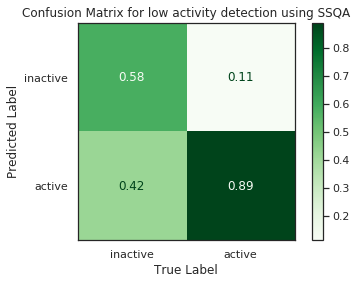

In [13]:
THRES = 0.45

cm = confusion_matrix(1-y_test, np.array(clf.predict_proba(X_test)[:,1] < THRES, dtype = int), normalize = "pred")

sns.set(style="white", palette="muted")
cmd = ConfusionMatrixDisplay(cm, display_labels=["inactive","active"])
ax = cmd.plot(cmap='Greens')
plt.title("Confusion Matrix for low activity detection using SSQA")
plt.ylabel("Predicted Label")
plt.xlabel("True Label")
plt.show()

In [30]:
sns.set(style="whitegrid", palette="muted")


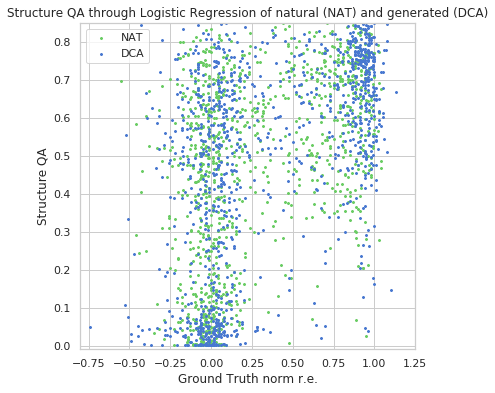

In [36]:
plt.figure(figsize=(6,6))
plt.scatter(df[(df.edca_below_50 == 1) &(df.origin == "NAT")]["norm r.e."].values, 
            df[(df.edca_below_50 == 1) &(df.origin == "NAT")]["struct QA"].values, c="g", marker="x", s=4)
plt.scatter(df[(df.edca_below_50 == 1) &(df.origin == "DCA")]["norm r.e."].values, 
            df[(df.edca_below_50 == 1) &(df.origin == "DCA")]["struct QA"].values, c="b", marker="x", s=4)
plt.legend(["NAT", "DCA"])
plt.xlabel("Ground Truth norm r.e.")
plt.ylabel("Structure QA")
plt.xlim(-0.8, 1.25)
plt.ylim(-0.01, 0.85)
plt.title("Structure QA through Logistic Regression of natural (NAT) and generated (DCA)")

plt.show()

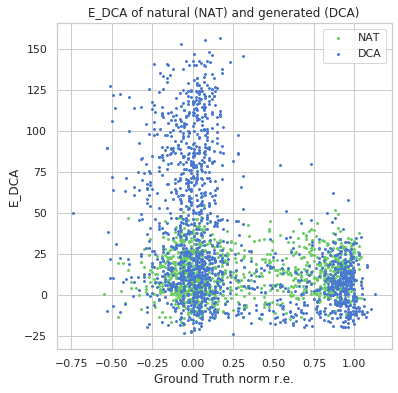

In [32]:
plt.figure(figsize=(6,6))
plt.scatter(df[(df.origin == "NAT")]["norm r.e."].values, 
            df[(df.origin == "NAT")]["EDCA (rel. to EcCM)"].values, s = 4.0, c="g", marker="x")
plt.scatter(df[(df.origin == "DCA")]["norm r.e."].values, 
            df[(df.origin == "DCA")]["EDCA (rel. to EcCM)"].values, s = 4.0, c="b", marker="x")
plt.legend(["NAT", "DCA"])
plt.xlabel("Ground Truth norm r.e.")
plt.ylabel("E_DCA")
# plt.xlim(-0.8, 1.25)
# plt.ylim(-0.01, 0.85)
plt.title("E_DCA of natural (NAT) and generated (DCA)")

plt.show()

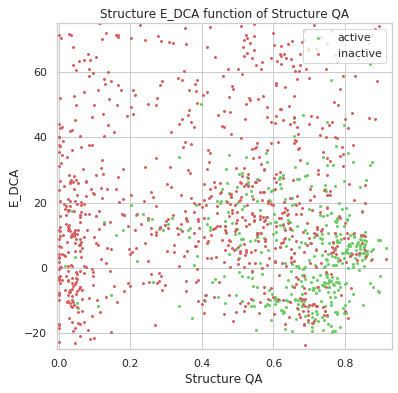

In [34]:
plt.figure(figsize=(6,6))
plt.scatter(df[(df.edca_below_50 <= 1) &(df.origin =="DCA") & (df.is_active == 1)]["struct QA"].values, 
            df[(df.edca_below_50 <= 1) &(df.origin =="DCA") & (df.is_active == 1)]["EDCA (rel. to EcCM)"].values, c="g", marker="o", s=4)
plt.scatter(df[(df.edca_below_50 <= 1) &(df.origin =="DCA") & (df.is_active == 0)]["struct QA"].values, 
            df[(df.edca_below_50 <= 1) &(df.origin =="DCA") & (df.is_active == 0)]["EDCA (rel. to EcCM)"].values, c="r", marker="x", s=4)
plt.legend(["active", "inactive"], loc = 1)
plt.xlabel("Structure QA")
plt.ylabel("E_DCA")
plt.xlim(-0.005, 0.93)
plt.ylim(-25, 75)
plt.title("Structure E_DCA function of Structure QA")

plt.show()

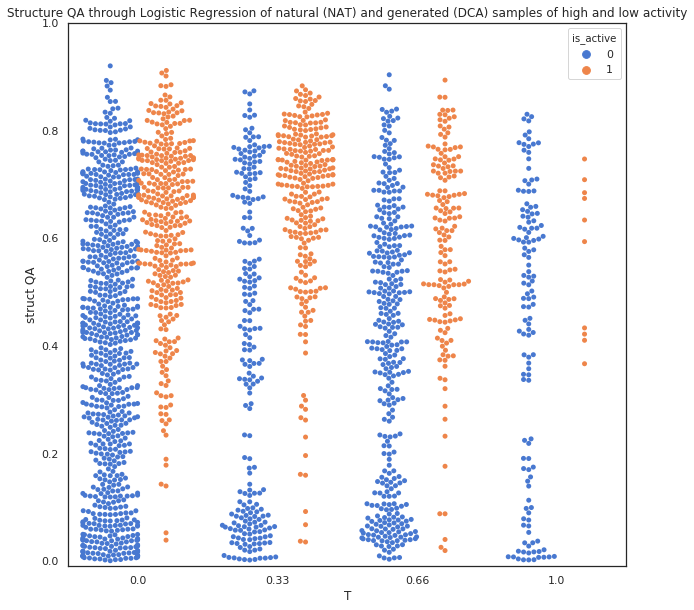

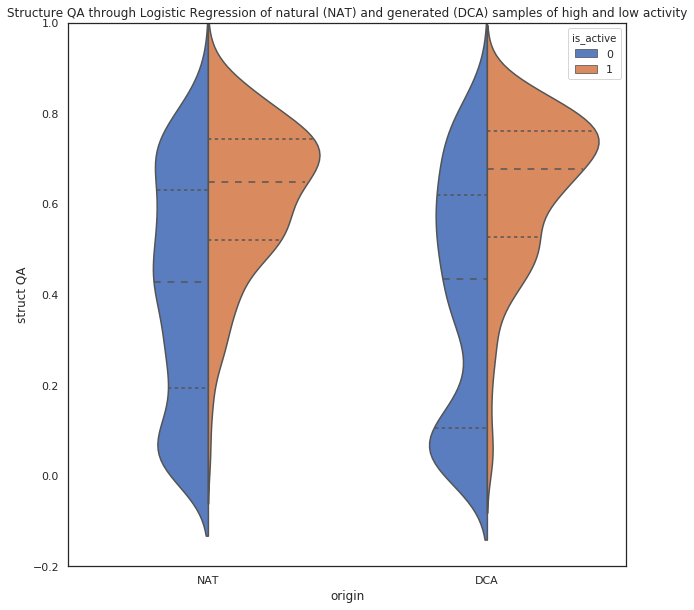

In [108]:
plt.figure(figsize=(10,10))
sns.swarmplot(x = "T", 
               y = "struct QA", 
               hue = "is_active", 
               data = df[df.edca_below_50 == 1], 
               palette = "muted",
               split = True,)
plt.title("Structure QA through Logistic Regression of natural (NAT) and generated (DCA) samples of high and low activity")
plt.ylim(-0.01, 1)
plt.show()

plt.figure(figsize=(10,10))
sns.violinplot(x = "origin", 
               y = "struct QA", 
               hue = "is_active", 
               data = df[df.edca_below_50 == 1], 
               inner = "quartile", 
               palette = "muted",
               split = True,)

plt.title("Structure QA through Logistic Regression of natural (NAT) and generated (DCA) samples of high and low activity")
plt.ylim(-0.2, 1)
plt.show()